In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import LabelEncoder

In [51]:
train_df = pd.read_csv('../Data/combined_train.csv')

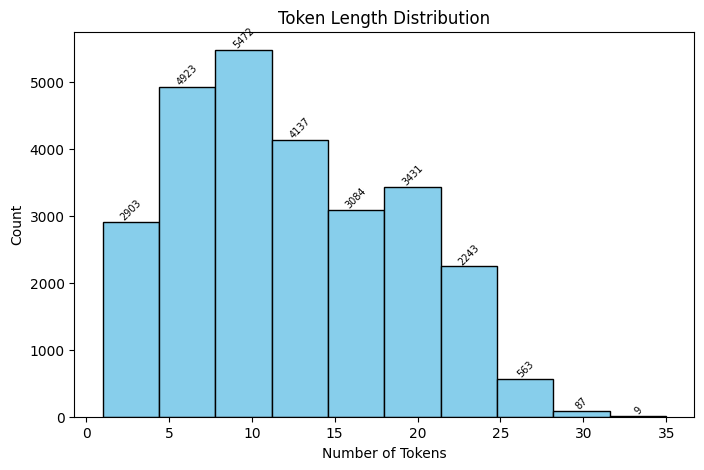

In [52]:
# Token length (for BERT), use:
train_df['token_length'] = train_df['text_cleaned'].astype(str).apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(8, 5))
counts, bins, patches = ax.hist(train_df['token_length'], color='skyblue', edgecolor='black')
ax.set_title('Token Length Distribution')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=7, rotation=45)

plt.show()

## Variable Distributions

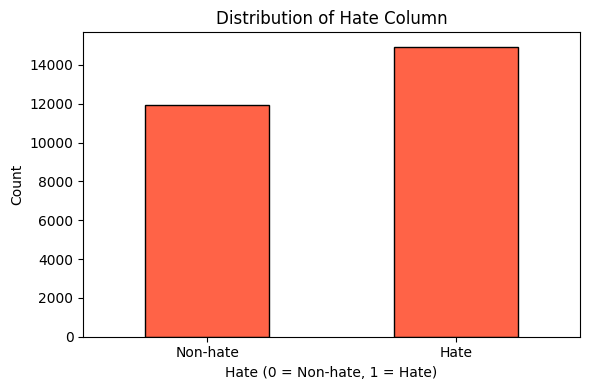

In [53]:
plt.figure(figsize=(6, 4))
train_df['hatespeech'].value_counts().sort_index().plot(
    kind='bar', color='tomato', edgecolor='black'
)
plt.title('Distribution of Hate Column')
plt.xlabel('Hate (0 = Non-hate, 1 = Hate)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-hate', 'Hate'], rotation=0)
plt.tight_layout()
plt.show()

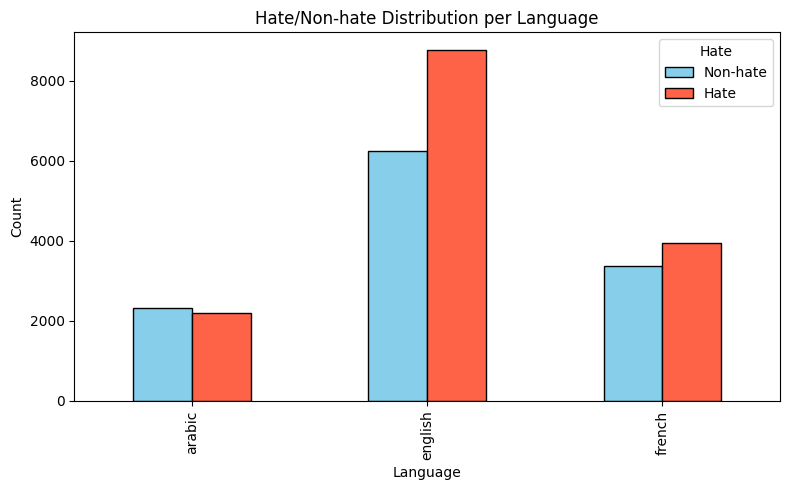

In [54]:
# Crosstab for hate/non-hate per language
hate_lang_ct = pd.crosstab(train_df['language'], train_df['hatespeech'])

# Plot
hate_lang_ct.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'tomato'], edgecolor='black')
plt.title('Hate/Non-hate Distribution per Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(['Non-hate', 'Hate'], title='Hate')
plt.tight_layout()
plt.show()

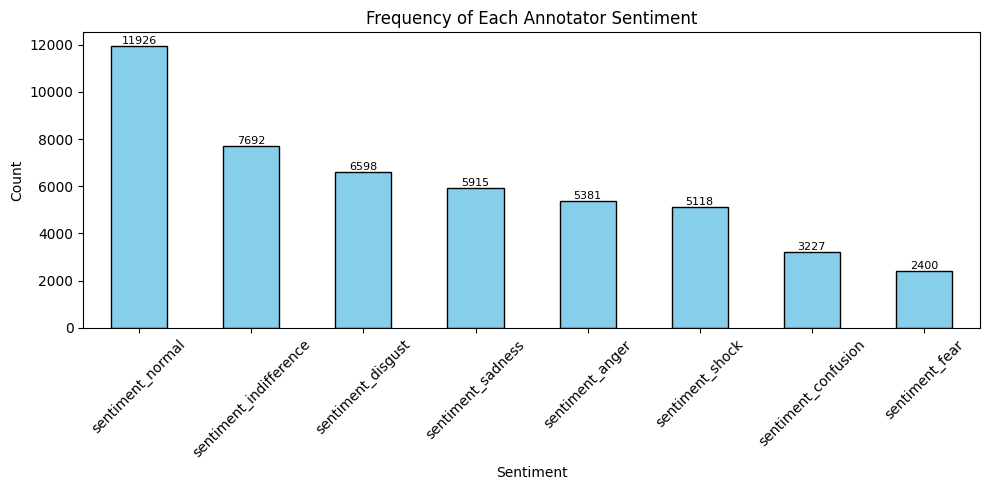

In [55]:
# List of sentiment columns
sentiment_cols = ['sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger',
                    'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear']

# Sum each sentiment column to get counts
sentiment_counts = train_df[sentiment_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
ax = sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Annotator Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value counts on top of bars
for i, count in enumerate(sentiment_counts):
    ax.text(i, count, str(int(count)), ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()

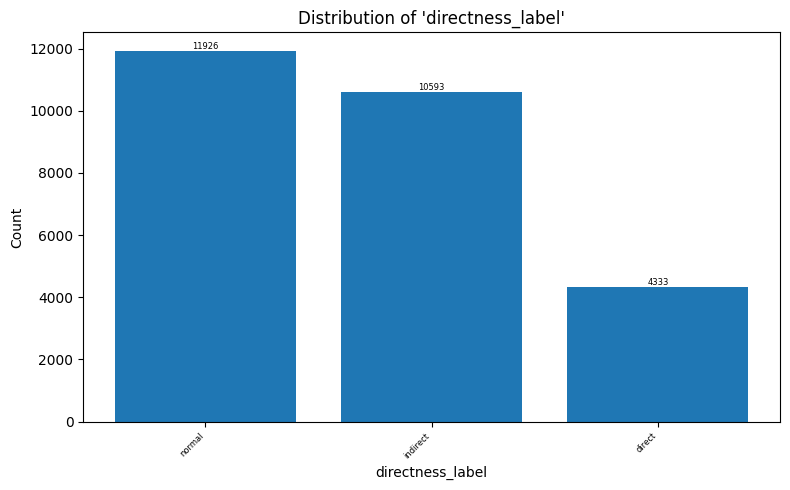

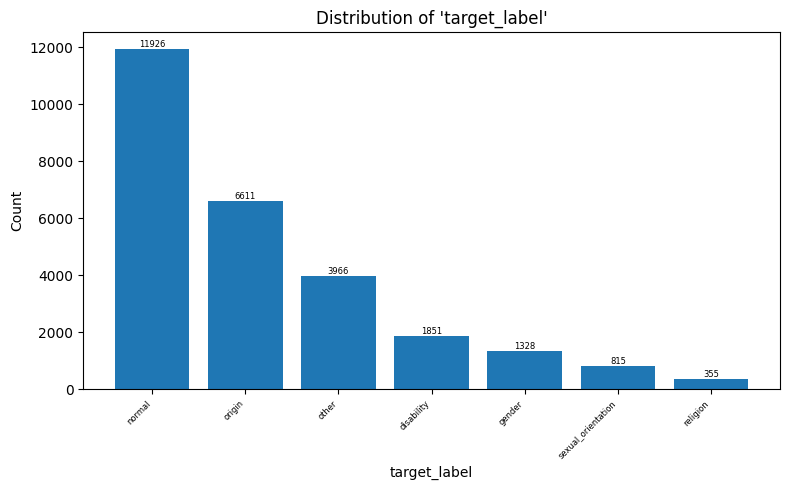

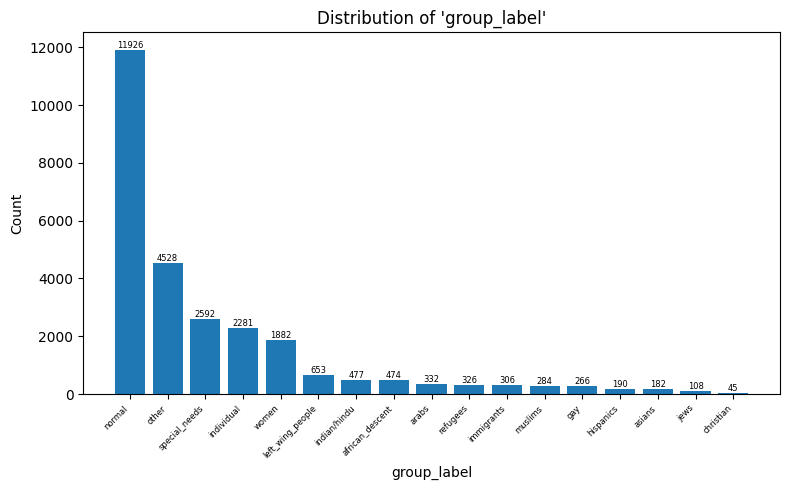

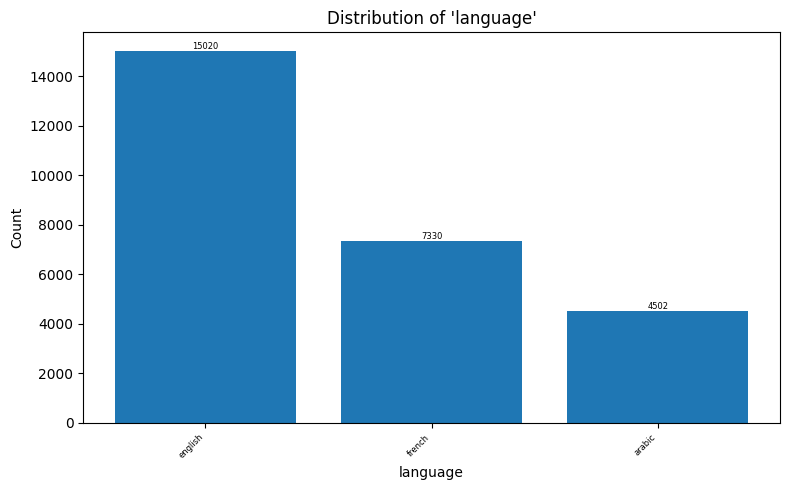

In [56]:
with open('../Data/label_maps.json', 'r') as f:
    label_maps = json.load(f)

def plot_distribution(column, label_map=None):
    value_counts = train_df[column].value_counts().sort_values(ascending=False)
    labels = value_counts.index.astype(str)
    if label_map:
        # Convert index to original labels if mapping provided
        labels = [label_map[str(idx)] if str(idx) in label_map else str(idx) for idx in value_counts.index]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, value_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f"Distribution of '{column}'")
    plt.xticks(rotation=45, ha='right', fontsize=6)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
                 ha='center', va='bottom', fontsize=6)
    plt.tight_layout()
    plt.show()

plot_distribution('directness_label', label_maps['directness'])
plot_distribution('target_label', label_maps['target'])
plot_distribution('group_label', label_maps['group'])
plot_distribution('language')  # No mapping needed if already string

## Correlation and Co-occurrences

                        language_label  directness_label  target_label  \
language_label                1.000000         -0.112452      0.032028   
directness_label             -0.112452          1.000000     -0.372860   
target_label                  0.032028         -0.372860      1.000000   
group_label                  -0.209803          0.198487     -0.311446   
sentiment_indifference       -0.003533         -0.473944      0.235437   
sentiment_disgust            -0.076142         -0.367491      0.096355   
sentiment_sadness             0.080625         -0.394248      0.104345   
sentiment_anger              -0.030479         -0.320010      0.099541   
sentiment_shock               0.014609         -0.383769      0.141033   
sentiment_normal             -0.022646          0.884358     -0.375968   
sentiment_confusion           0.008587         -0.234369      0.067581   
sentiment_fear                0.021757         -0.220879      0.050626   

                        group_label  

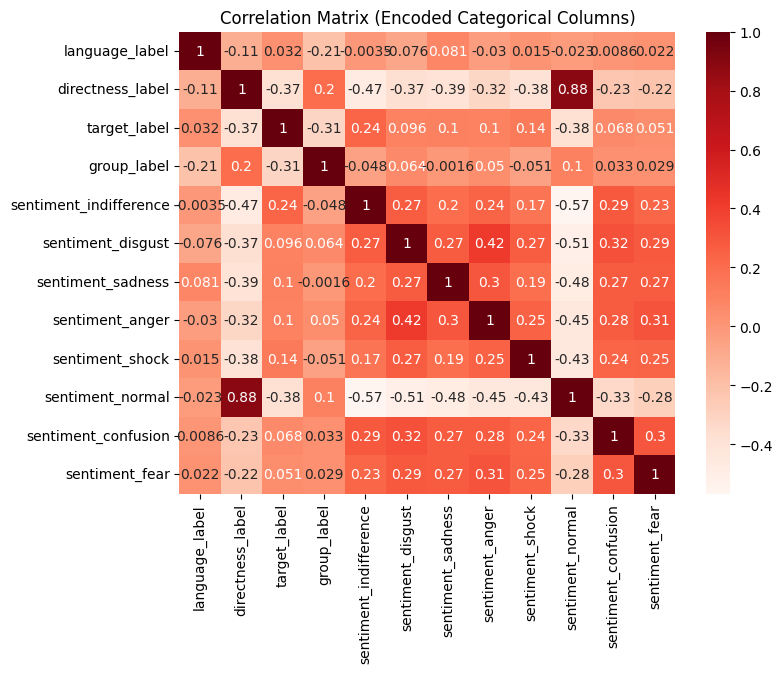

In [57]:
le = LabelEncoder()
train_df['language_label'] = le.fit_transform(train_df['language'].astype(str))

# Label encode the 5 categorical columns
categorical_cols = ['language_label', 'directness_label', 'target_label', 'group_label',
                    'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger',
                    'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear']

# Create a DataFrame with only the encoded columns
encoded_df = train_df[[col for col in categorical_cols]]

# Show correlation matrix for the encoded categorical columns
correlation_matrix = encoded_df.corr()
print(correlation_matrix)

# Optional: visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.title('Correlation Matrix (Encoded Categorical Columns)')
plt.show()


Language Cooccurrences


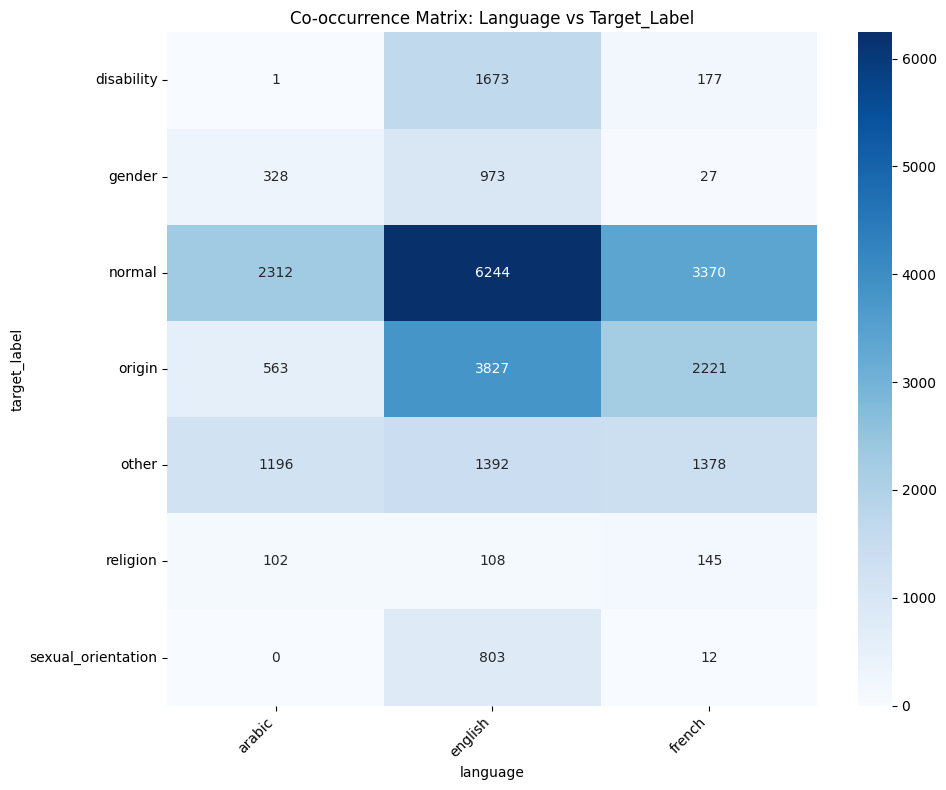

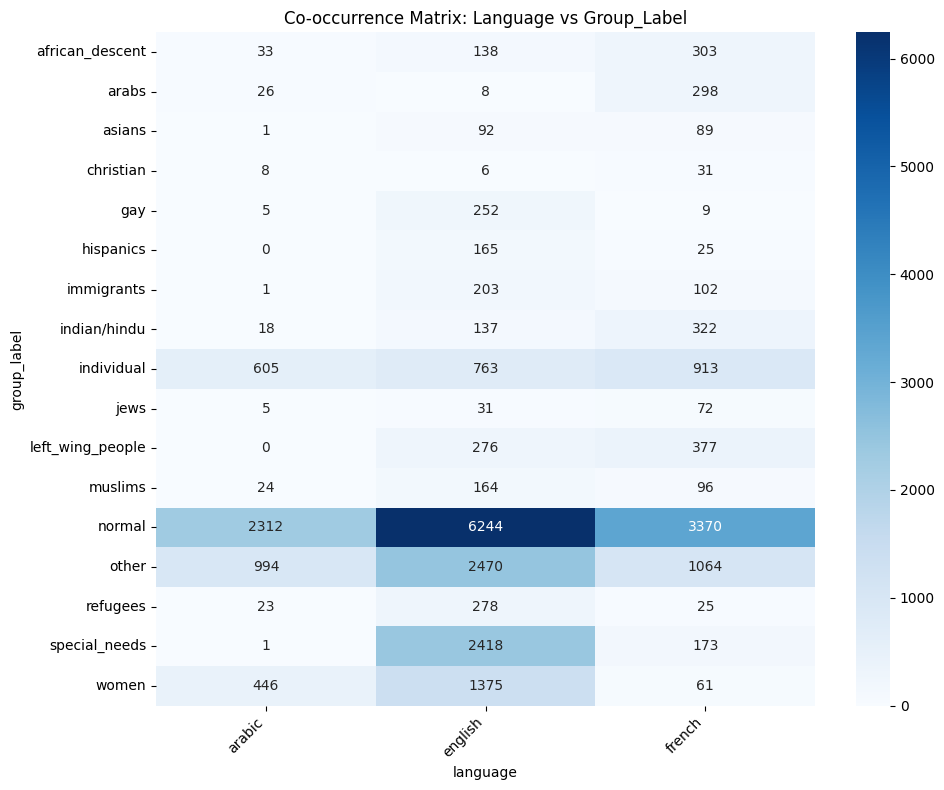


Directness Cooccurrences


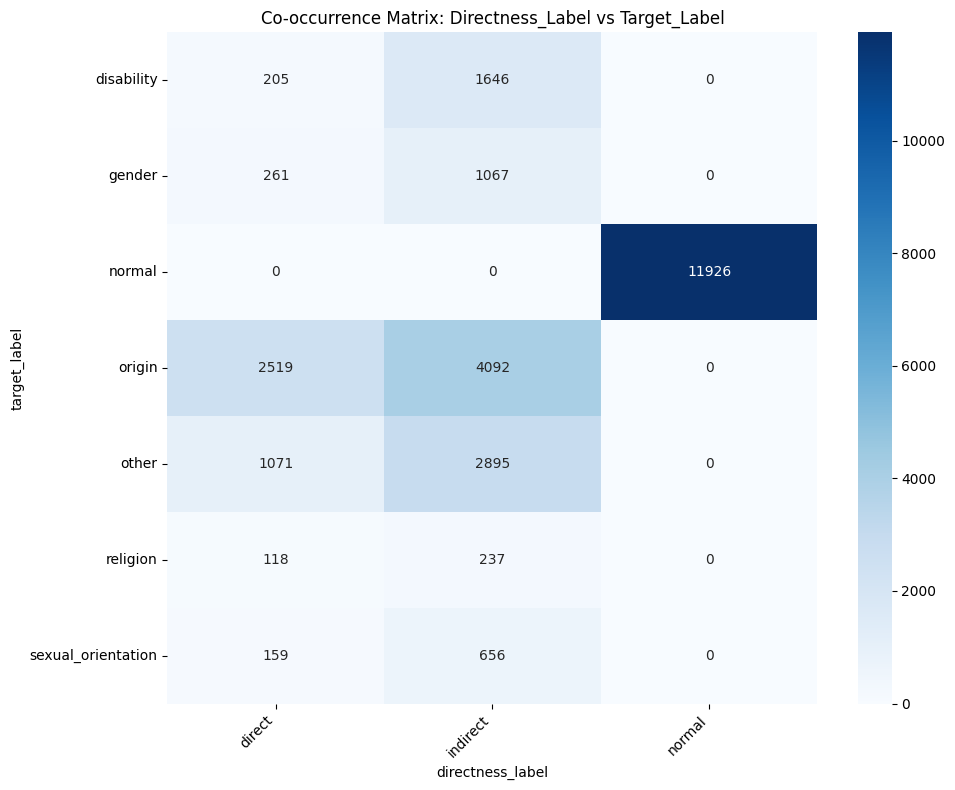

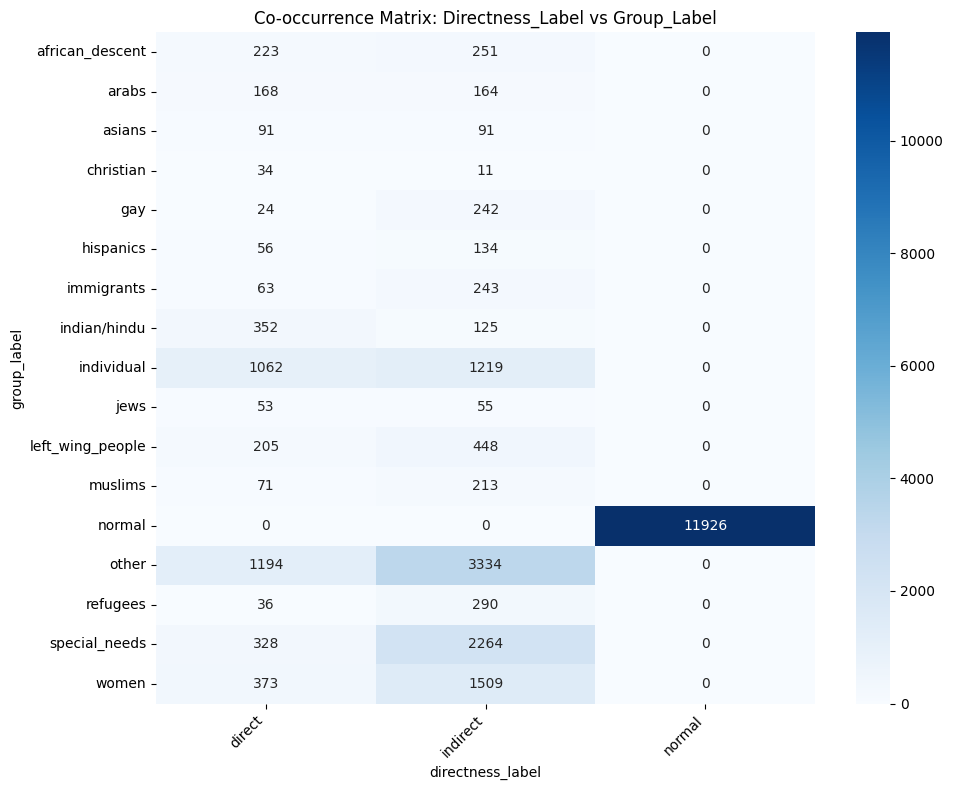

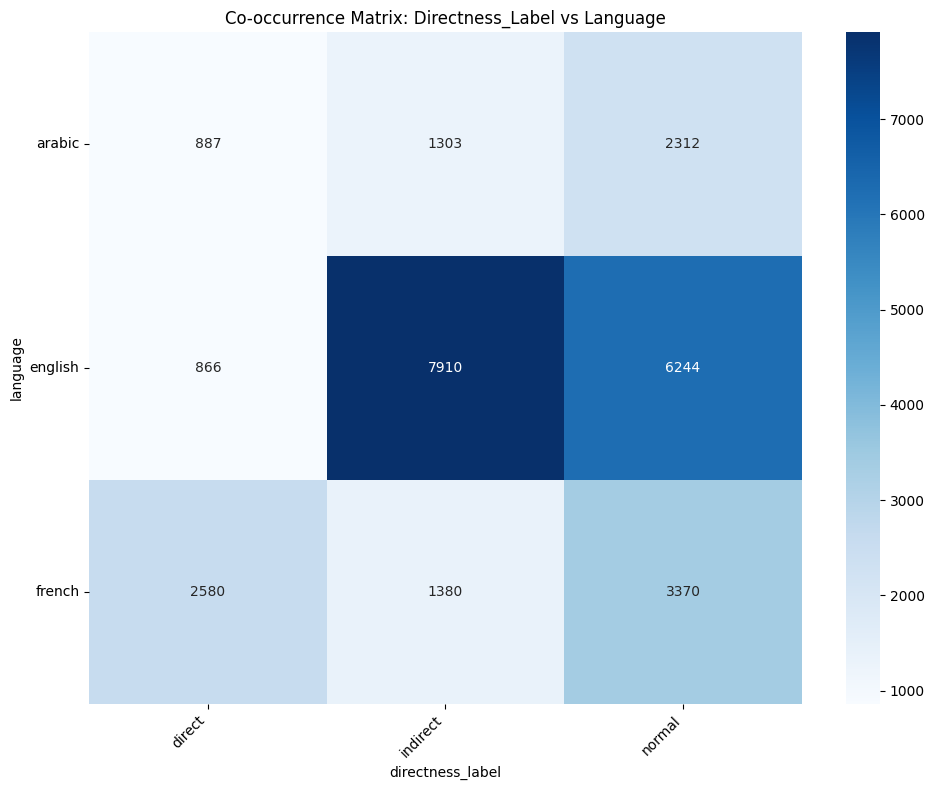


Group vs. Target


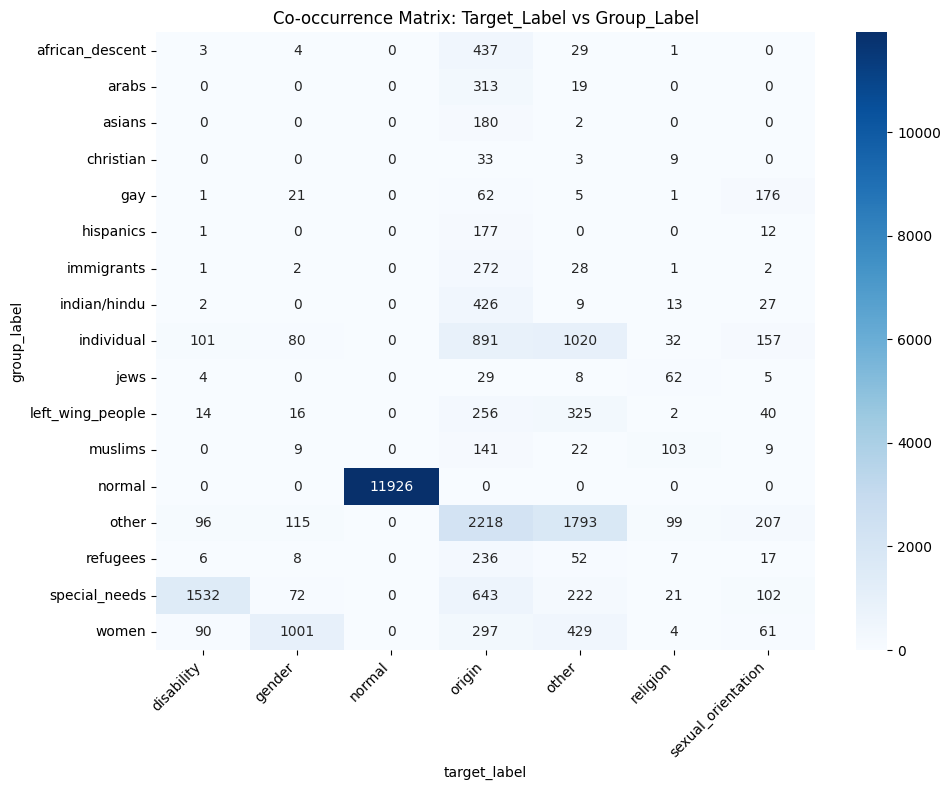

In [58]:
def decode_labels(values, label_map):
    # values: list or index of ints or strings
    # label_map: dict with string keys
    return [label_map.get(str(v), str(v)) for v in values]

def plot_cooccurrence_matrix(col1, col2, col1_name, col2_name, row_map=None, col_map=None):
    cooccurrence = pd.crosstab(
        train_df[col1_name], train_df[col2_name]
    ).reindex(index=col1, columns=col2, fill_value=0)
    # Decode row and column labels if mapping provided
    row_labels = decode_labels(cooccurrence.index, row_map) if row_map else cooccurrence.index.astype(str)
    col_labels = decode_labels(cooccurrence.columns, col_map) if col_map else cooccurrence.columns.astype(str)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title(f'Co-occurrence Matrix: {col2_name.title()} vs {col1_name.title()}')
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

directness = sorted(train_df['directness_label'].unique())
target = sorted(train_df['target_label'].unique())
group = sorted(train_df['group_label'].unique())
language = sorted(train_df['language'].unique())

print("\nLanguage Cooccurrences")
plot_cooccurrence_matrix(target, language, 'target_label', 'language',
                         row_map=label_maps['target'], col_map=None)
plot_cooccurrence_matrix(group, language, 'group_label', 'language',
                         row_map=label_maps['group'], col_map=None)
print("\nDirectness Cooccurrences")
plot_cooccurrence_matrix(target, directness, 'target_label', 'directness_label',
                         row_map=label_maps['target'], col_map=label_maps['directness'])
plot_cooccurrence_matrix(group, directness, 'group_label', 'directness_label',
                         row_map=label_maps['group'], col_map=label_maps['directness'])
plot_cooccurrence_matrix(language, directness, 'language', 'directness_label',
                         row_map=None, col_map=label_maps['directness'])
print("\nGroup vs. Target")
plot_cooccurrence_matrix(group, target, 'group_label', 'target_label',
                         row_map=label_maps['group'], col_map=label_maps['target'])

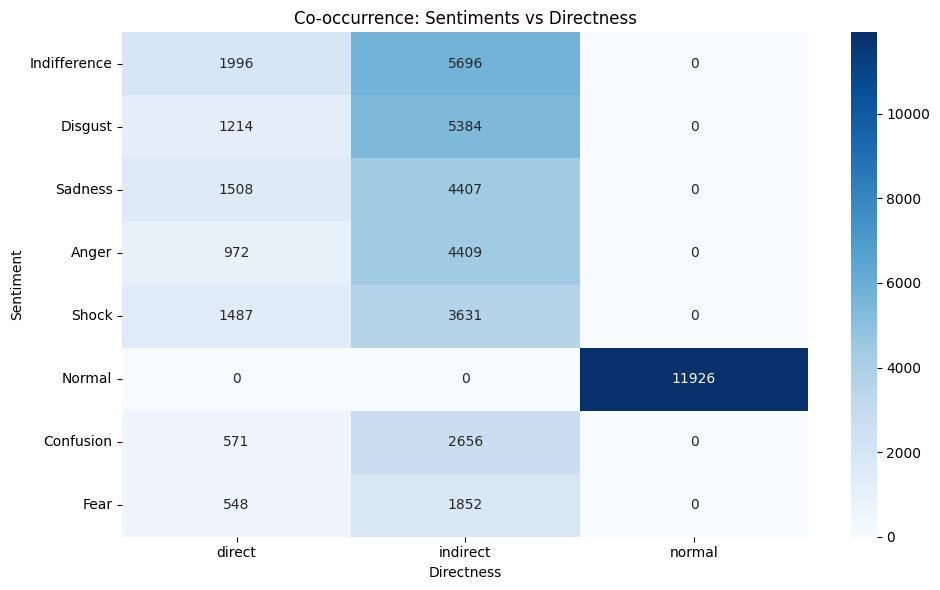

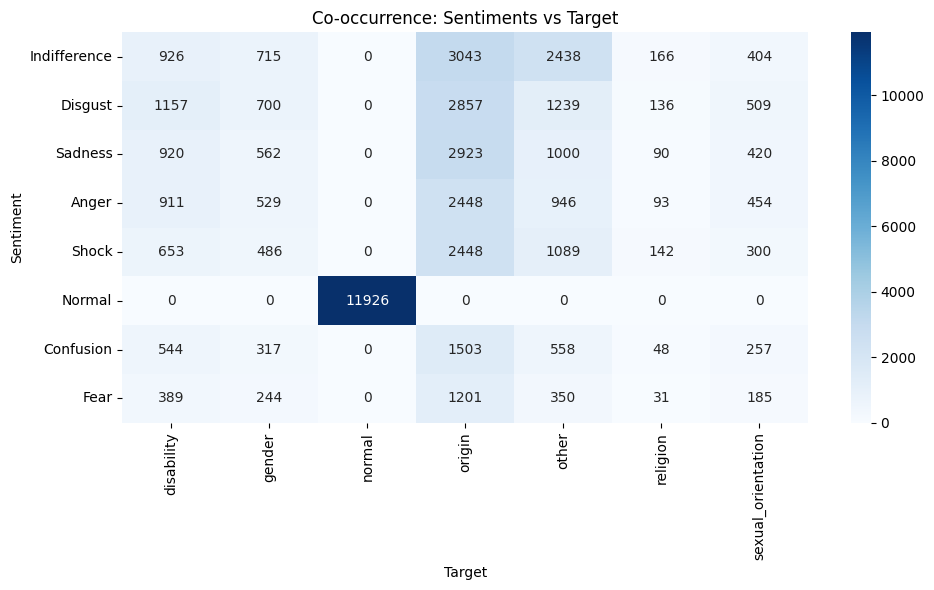

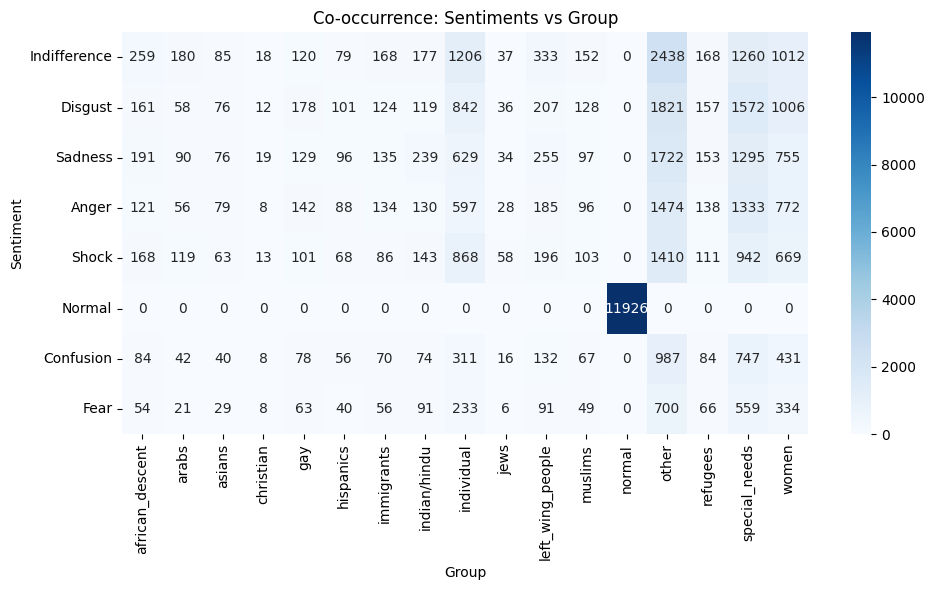

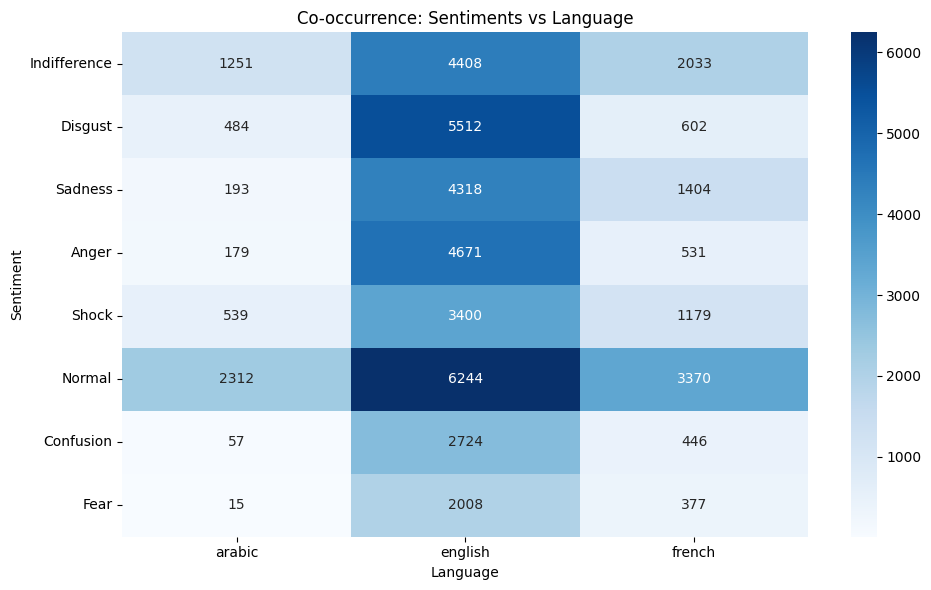

In [59]:
cooccurrence_targets = ['directness_label', 'target_label', 'group_label', 'language']

# Optionally, create a sentiment label map for pretty y-axis labels
sentiment_label_map = {col.replace('sentiment_', ''): col.replace('sentiment_', '').capitalize() for col in sentiment_cols}

for target_col in cooccurrence_targets:
    valid_sentiments = [col for col in sentiment_cols if col in train_df.columns]
    if not valid_sentiments:
        continue

    cooccurrence = pd.DataFrame(
        {sentiment.replace('sentiment_', ''): train_df.groupby(target_col)[sentiment].sum()
         for sentiment in valid_sentiments}
    ).T

    # Use label maps for x-axis (target_col)
    if target_col.replace('_label', '') in label_maps:
        label_map = label_maps[target_col.replace('_label', '')]
        col_labels = [label_map.get(str(idx), str(idx)) for idx in cooccurrence.columns]
    else:
        col_labels = cooccurrence.columns.astype(str)

    # Use sentiment label map for y-axis
    row_labels = [sentiment_label_map.get(idx, idx) for idx in cooccurrence.index]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title(f"Co-occurrence: Sentiments vs {target_col.replace('_label','').title()}")
    plt.xlabel(target_col.replace('_label','').title())
    plt.ylabel('Sentiment')
    plt.tight_layout()
    plt.show()

## Exploring Language Differences

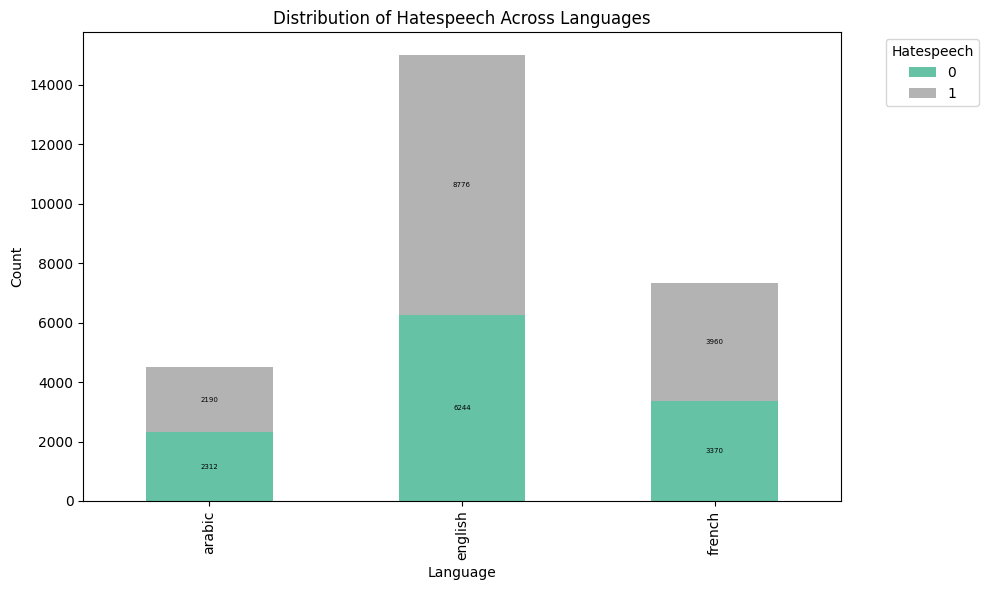

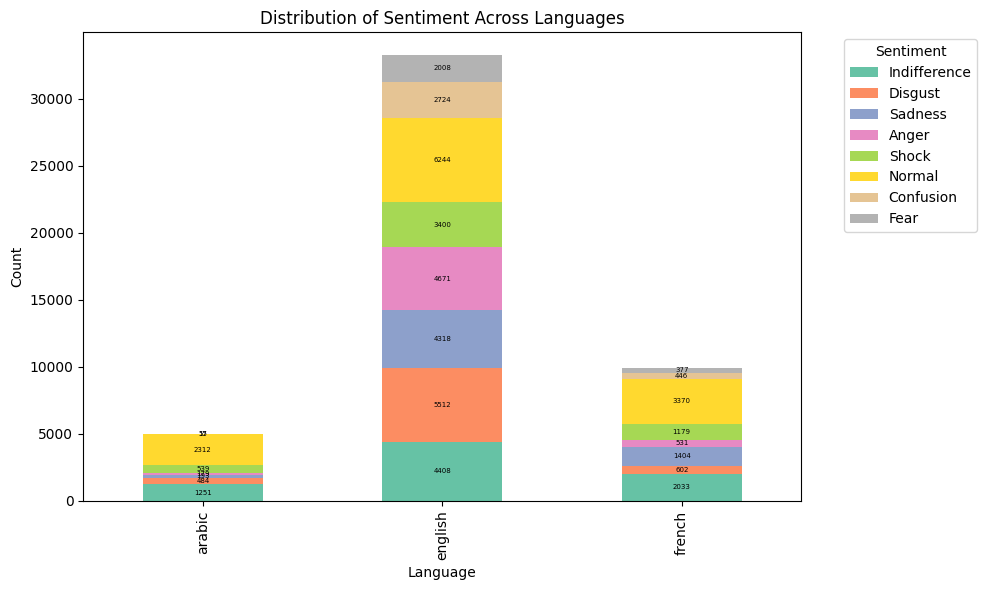

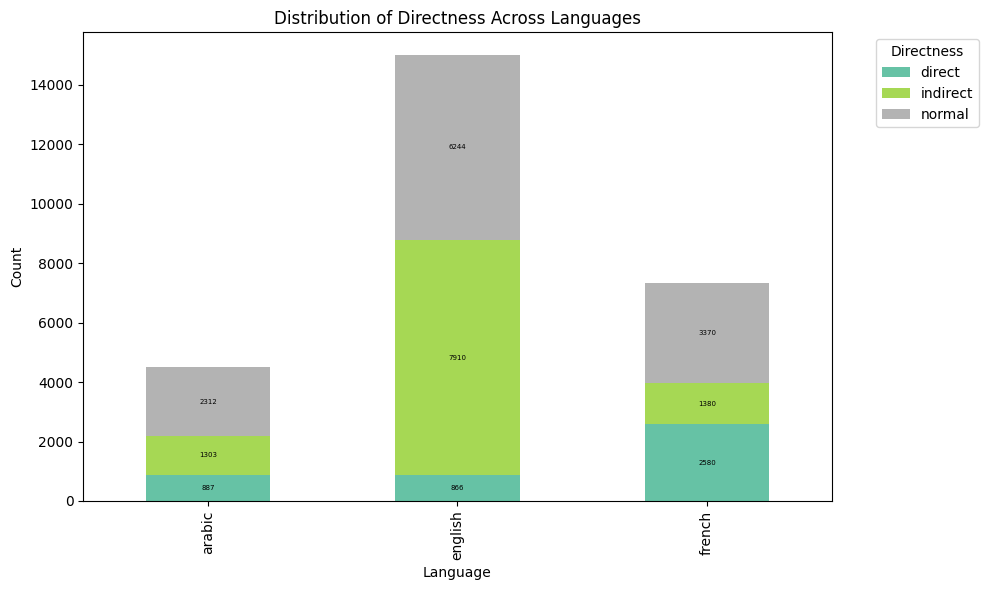

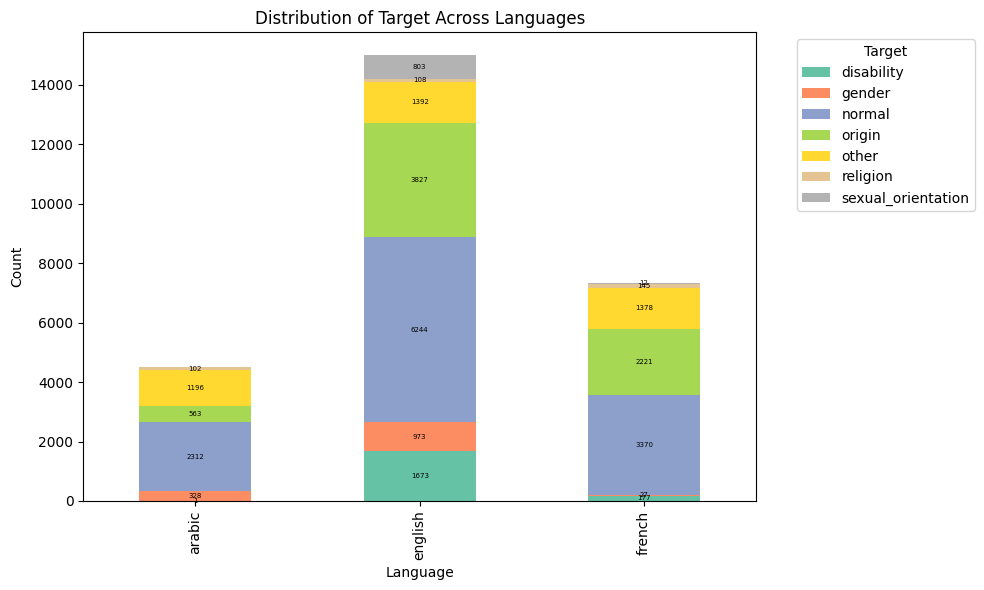

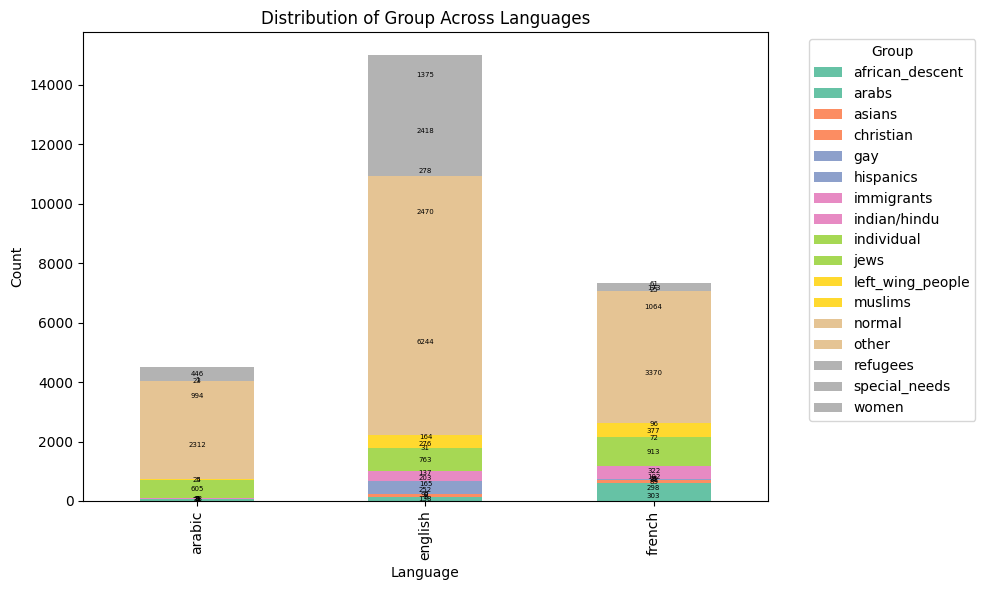

In [60]:
# Language vs. Label Distribution: Stacked Bar Plot (with label maps)
for label in ['hatespeech', 'sentiment', 'directness', 'target', 'group']:
    plt.figure(figsize=(10, 6))
    if label == 'sentiment':
        # Sentiment columns already have readable names
        lang_label_counts = train_df.groupby('language')[sentiment_cols].sum()
        legend_labels = [col.replace('sentiment_', '').capitalize() for col in sentiment_cols]
        lang_label_counts.columns = legend_labels
    else:
        label_col = f"{label}_label" if f"{label}_label" in train_df.columns else label
        lang_label_counts = pd.crosstab(train_df['language'], train_df[label_col])
        # Map legend labels if available
        if label in label_maps:
            legend_labels = [label_maps[label].get(str(idx), str(idx)) for idx in lang_label_counts.columns]
            lang_label_counts.columns = legend_labels
        else:
            legend_labels = lang_label_counts.columns.astype(str)
    ax = lang_label_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10,6), ax=plt.gca())
    plt.title(f'Distribution of {label.title()} Across Languages')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.legend(title=label.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Add value counts on top of each bar segment
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                            (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                            ha='center', va='center', fontsize=5, color='black')
    plt.show()

In [61]:
def show_samples_per_class_per_language(column, n=3):
    print(f"\nSample texts for each {column} per language:")
    for lang in train_df['language'].dropna().unique():
        print(f"\n=== Language: {lang} ===")
        if column == 'sentiment':
            for sentiment_col in sentiment_cols:
                sentiment_key = sentiment_col.replace('sentiment_', '')
                sentiment_name = sentiment_key.capitalize()
                print(f"\n--- Sentiment: {sentiment_name} ---")
                samples = train_df[(train_df['language'] == lang) & (train_df[sentiment_col] == 1)]['text_cleaned'].dropna().head(n)
                if samples.empty:
                    print("No samples available.")
                else:
                    for i, text in enumerate(samples, 1):
                        print(f"{i}. {text}")
        else:
            # Use label map if available
            label_key = column.replace('_label', '')
            label_map = label_maps.get(label_key, {})
            classes = train_df[column].dropna().unique()
            for cls in classes:
                class_name = label_map.get(str(cls), str(cls))
                print(f"\n--- {column.title()}: {class_name} ---")
                samples = train_df[(train_df['language'] == lang) & (train_df[column] == cls)]['text_cleaned'].dropna().head(n)
                if samples.empty:
                    print("No samples available.")
                else:
                    for i, text in enumerate(samples, 1):
                        print(f"{i}. {text}")

In [62]:
show_samples_per_class_per_language('directness_label', n=3)  


Sample texts for each directness_label per language:

=== Language: arabic ===

--- Directness_Label: normal ---
1. رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرضةً عن الصُلح . . ! @ مدينة الحصن
2. اي كذبه فيهم
3. عمريي انتي مانحرم

--- Directness_Label: indirect ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
3. صباح التوكل على الله والسعي على رزقه والثقة فيما عنده #افريقيا_يا_اهلى

--- Directness_Label: direct ---
1. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه
2. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات
3. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب

=== Language: french ===

--- Directness_Label: normal ---
1. Mais crÃ¨ve ton existence ?
2. vien jouer sale arabe
3. si t'avais pas envoyé ma photo on en serait pas là pauline

--- Directness_Label: indirect ---
1. bah oui t'as raison l'autre c'est un mongol.
2. c...est vrai que les anc

In [63]:
show_samples_per_class_per_language('target_label', n=3)  


Sample texts for each target_label per language:

=== Language: arabic ===

--- Target_Label: normal ---
1. رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرضةً عن الصُلح . . ! @ مدينة الحصن
2. اي كذبه فيهم
3. عمريي انتي مانحرم

--- Target_Label: gender ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه
3. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات

--- Target_Label: other ---
1. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
2. صباح التوكل على الله والسعي على رزقه والثقة فيما عنده #افريقيا_يا_اهلى
3. و مدعمتهاش ليه فى كاس العالم يا جبان يا وسخ

--- Target_Label: origin ---
1. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب
2. يعني مش هيك بعبرو عن التحرش الجنسي بلبنان
3. والضرب في كسمك حلال مفيش حد يقدر يغلب مصري في الكلال كسمك ع كسمه ي شواذ ي ولاد الوسخة بتشك…

--- Target_Label: religion ---
1. لا هندوس
2. والله هدف ما يدخل في فريق فئات سنية.. هدف سا

In [64]:
show_samples_per_class_per_language('group_label', n=3)  


Sample texts for each group_label per language:

=== Language: arabic ===

--- Group_Label: normal ---
1. رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرضةً عن الصُلح . . ! @ مدينة الحصن
2. اي كذبه فيهم
3. عمريي انتي مانحرم

--- Group_Label: individual ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
3. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه

--- Group_Label: other ---
1. صباح التوكل على الله والسعي على رزقه والثقة فيما عنده #افريقيا_يا_اهلى
2. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب
3. يارب انصرنا #افريقيا_يا_اهلي

--- Group_Label: women ---
1. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات
2. واضح انكم تكذبوها ع سالفه ان الحريم يقعدن بالارض ولا انا فهمت غلط ودرعمت؟
3. واحده بايره

--- Group_Label: indian/hindu ---
1. والله هندوس ع وش اللي جابوهم السبت
2. لا هندوس
3. كف كموم زنود ثوبك يدك ادخله حان وقت اصلا دود علي فران هندوس

--- Gro

In [65]:
show_samples_per_class_per_language('sentiment', n=3)  


Sample texts for each sentiment per language:

=== Language: arabic ===

--- Sentiment: Indifference ---
1. طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم بدون .......
2. ما عارف كنت شايفها منحرفة شديد وانا صغير ليه
3. صباح التوكل على الله والسعي على رزقه والثقة فيما عنده #افريقيا_يا_اهلى

--- Sentiment: Disgust ---
1. وانتي مال امك يا مطلقة يا بايرة ياوش قنوات
2. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب
3. و مدعمتهاش ليه فى كاس العالم يا جبان يا وسخ

--- Sentiment: Sadness ---
1. يارب انصرنا #افريقيا_يا_اهلي
2. let guess اللاجئون السوريون؟
3. بدون شك بريئين منها. أنا ترى ما قلت سواقة حريم

--- Sentiment: Anger ---
1. كلهم خنازير المجوس
2. بدون شك بريئين منها. أنا ترى ما قلت سواقة حريم
3. اووووه يممممااااه تصدق خوفتني يا خنزير

--- Sentiment: Shock ---
1. صلاة الفجر خير لك من ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية #عقلانيون
2. الكردي كلب من يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب
3. ي قصارية ي بايرة
